In [1]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests

In [2]:
# Census API Key
from env.config import api_key

In [3]:
# Query 2014-2060 projected population
year='2014'
dsource='pep'
dname='projpop'
cols='POP,YEAR'
base_url = f'https://api.census.gov/data/{year}/{dsource}/{dname}'
data_url = f'{base_url}?get={cols}&for=us:1&key={api_key}'
response=requests.get(data_url)

In [4]:
# Check status code
if response.status_code != 200:
    print ("Error!")
else:
    print ("Sucess!")
    response_json = response.json()

Sucess!


In [5]:
# Copy YEAR and POP lists from JSON response to new lists
total_pop=[]
year=[]
for x in range(1,len(response_json)):
    total_pop.append(int(response_json[x][0]))
    year.append(int(response_json[x][1]))

In [41]:
# Create growth rate list per year based on difference between year N+! and year 1. 
# The first two entries in the table are for 2014 and 2015. We use these to set
# the initial growth rate and use it for the first entry in the growth_rate list,
# which starts at year 2016, which is the first year for which we have projected populationg
# data in the CSV file used by other code in this project.
# Growth rate is essentially the first derivative; it shows the amount by which the population
# is growing or shrinking year over year.

growth_initial = total_pop[1] - total_pop[0]

growth_rate = []

avg_growth_rate = growth_initial

for x in range(2,len(total_pop)):
    if x == 2:
        growth_rate.append(growth_initial)
    elif x == 3:
        growth_rate.append(total_pop[x] - total_pop[x-1])
    else:
        growth_rate.append(total_pop[x] - total_pop[x-1])
        avg_growth_rate = int((avg_growth_rate + growth_rate[-1])/2)
    
# Now compute the growth rate change. This is essentially the second derivative; it shows
# the amount by which the population growth is going up or down year over year.

growth_rate_change = []
avg_growth_rate_change = 0
total_growth_rate_change = 0
growth_rate_change_initial = growth_rate[0] - growth_rate[1]
for x in range(0,len(growth_rate)):
    if x == 0:
        growth_rate_change.append(growth_rate_change_initial)
    else:
        growth_rate_change.append(growth_rate[x-1] - growth_rate[x])
    total_growth_rate_change -= growth_rate_change[-1]

avg_growth_rate_change = int(total_growth_rate_change / len(growth_rate)) - 2400

In [69]:
# Now that we have the growth rate and growth rate change lists, use these to create projected
# population lists, i,e. the population itself and the corresponding years.

proj_pop = total_pop.copy()
proj_year = year.copy()

new_growth_rate = avg_growth_rate
while new_growth_rate > 0:
    proj_year.append(proj_year[-1] + 1)
    proj_pop.append(proj_pop[-1] + new_growth_rate)
    new_growth_rate += avg_growth_rate_change  


In [70]:
# Extend the data another 50 years so we can see the knee of the curve when
# the rate of population change starts to go down because of the low TFR.
for x in range(50):
    proj_year.append(proj_year[-1] + 1)
    proj_pop.append(proj_pop[-1] + new_growth_rate)
    new_growth_rate += avg_growth_rate_change 


In [71]:
# Now calculate the reduction in population rates from 2019 on by the NIM change from 2018
nim_decrease = 1001528 - 595348

In [82]:
# Now create lists similar to the growth rate lists reflecting the change in NIM
nim_total_pop = total_pop.copy()
nim_growth_initial = nim_total_pop[1] - nim_total_pop[0]
nim_growth_rate = []
nim_avg_growth_rate = nim_growth_initial

for x in range(0,len(nim_total_pop)):
    if x == 0:
        nim_growth_rate.append(nim_growth_initial - nim_decrease)
    elif x == 2:
        nim_growth_rate.append(nim_total_pop[x] - nim_total_pop[x-1] - nim_decrease)
    else:
        nim_growth_rate.append(nim_total_pop[x] - nim_total_pop[x-1] - nim_decrease)
        nim_avg_growth_rate = int((nim_avg_growth_rate + nim_growth_rate[-1])/2)

nim_growth_rate_change = []
nim_avg_growth_rate_change = 0
nim_total_growth_rate_change = 0
nim_growth_rate_change_initial = nim_growth_rate[0] - nim_growth_rate[1]

for x in range(0,len(nim_growth_rate)):
    if x == 0:
        nim_growth_rate_change.append(nim_growth_rate_change_initial)
    else:
        nim_growth_rate_change.append(nim_growth_rate[x-1] - nim_growth_rate[x])
    nim_total_growth_rate_change -= nim_growth_rate_change[-1]

nim_avg_growth_rate_change = int((nim_growth_rate_change[x-1] + nim_growth_rate_change[x])/2) - 2400

In [83]:
# Apply the growth rate change to the projected population lists.
nim_proj_pop = nim_total_pop.copy()
nim_proj_year = year.copy()

nim_new_growth_rate = nim_avg_growth_rate
while nim_new_growth_rate > 0:
    nim_proj_year.append(nim_proj_year[-1] + 1)
    nim_proj_pop.append(nim_proj_pop[-1] + nim_new_growth_rate)
    nim_new_growth_rate += nim_avg_growth_rate_change   


In [84]:
# Extend the data another 50 years
for x in range(50):
    nim_proj_year.append(nim_proj_year[-1] + 1)
    nim_proj_pop.append(nim_proj_pop[-1] + nim_new_growth_rate)
    nim_new_growth_rate += nim_avg_growth_rate_change 


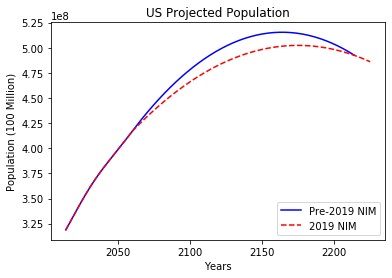

In [85]:
# plot data using line graph
ax, fig = plt.subplots()
plt.title('US Projected Population')
plt.xlabel('Years')
plt.ylabel('Population (100 Million)')
current_nim = fig.plot(proj_year, proj_pop, color = "blue", label = "Pre-2019 NIM")
low_nim = fig.plot(nim_proj_year, nim_proj_pop, color = "red", linestyle='dashed', label = "2019 NIM")
plt.legend(loc="lower right")

In [77]:
ax.savefig("Images/US_Projected_Population.png")
plt.show()